Sonification
=======

First, let's import dependencies:

In [1]:
%matplotlib notebook

import math
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
import pygame

import sound_drivers.pa_tools as pa_tools
import sound_drivers.pg_tools as pg_tools
import sound_drivers.sc_tools as sc_tools

from synth import get_frequencies

Initialize audio:

In [2]:
pa_tools.init_audio()
pg_tools.init_audio()
sc_tools.init_audio()

2017-10-06 22:53:30,206 [acoustic_sight] [DEBUG] Initializing PyGame mixer...
2017-10-06 22:53:30,229 [acoustic_sight] [INFO] PyAudio initialized: {'pyaudio': <pyaudio.PyAudio object at 0x103047978>, 'bitrate': 96000, 'channels': 1}
2017-10-06 22:53:30,231 [acoustic_sight] [DEBUG] Initializing PyGame mixer...
2017-10-06 22:53:30,369 [acoustic_sight] [INFO] PyGame mixer initialized: (88200, -16, 1)
2017-10-06 22:53:30,370 [acoustic_sight] [DEBUG] Starting SuperCollider server...
2017-10-06 22:53:30,764 [acoustic_sight] [INFO] SuperCollider server started: supriya.tools.servertools.Server(
    ip_address='127.0.0.1',
    port=57751,
    )


Play PyAudio sine wave at 440 Hz:

In [3]:
pa_440 = pa_tools.PAMultiTone([440.], .5)
pa_440.play()
time.sleep(1)
pa_440.stop()

2017-10-06 22:53:35,953 [acoustic_sight] [DEBUG] Generate 440.0 Hz component
2017-10-06 22:53:35,955 [acoustic_sight] [DEBUG] Add amplified 440.0 Hz component
2017-10-06 22:53:35,956 [acoustic_sight] [DEBUG] Generate 440.0 Hz component
2017-10-06 22:53:35,957 [acoustic_sight] [DEBUG] Add amplified 440.0 Hz component
2017-10-06 22:53:35,958 [acoustic_sight] [DEBUG] Generate 440.0 Hz component
2017-10-06 22:53:35,960 [acoustic_sight] [DEBUG] Add amplified 440.0 Hz component
2017-10-06 22:53:35,976 [acoustic_sight] [DEBUG] Generate 440.0 Hz component
2017-10-06 22:53:35,977 [acoustic_sight] [DEBUG] Add amplified 440.0 Hz component
2017-10-06 22:53:35,978 [acoustic_sight] [DEBUG] Generate 440.0 Hz component
2017-10-06 22:53:35,980 [acoustic_sight] [DEBUG] Add amplified 440.0 Hz component
2017-10-06 22:53:35,999 [acoustic_sight] [DEBUG] Generate 440.0 Hz component
2017-10-06 22:53:36,000 [acoustic_sight] [DEBUG] Add amplified 440.0 Hz component
2017-10-06 22:53:36,002 [acoustic_sight] [DEBU

Play PyGame sine wave at 440 Hz:

In [4]:
pg_440 = pg_tools.PGTone(440., .1)
pg_440.play(-1)
time.sleep(1)
pg_440.stop()

Play SuperCollider sine wave at 440 Hz:

In [5]:
sc_440 = sc_tools.SCTone(440., .1)
sc_440.play()
time.sleep(1)
sc_440.stop()

2017-10-06 22:53:44,161 [acoustic_sight] [DEBUG] Create dedicated SuperCollider tone group: supriya.tools.servertools.Group(
    children=(),
    )
2017-10-06 22:53:44,219 [acoustic_sight] [DEBUG] Pushed tone synth for 440.0 Hz to SuperColider server
2017-10-06 22:53:45,221 [acoustic_sight] [DEBUG] Released tone synth for 440.0 Hz from SuperColider server


Create signals:

<IPython.core.display.Javascript object>


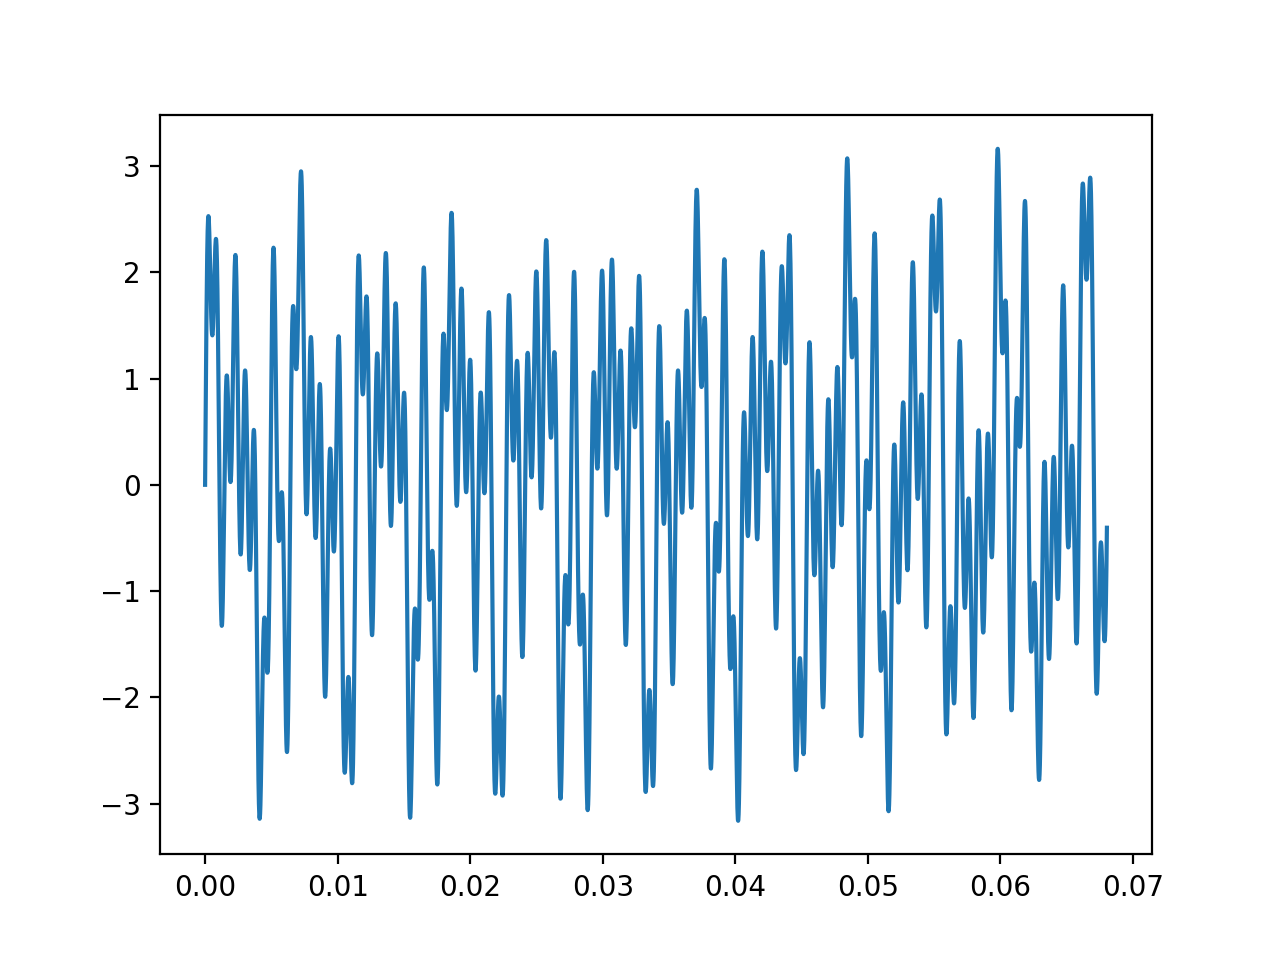

In [14]:
sample_rate = pygame.mixer.get_init()[0]
frame_size = 1500 * 4
frame_period = frame_size / sample_rate
time_vector = np.linspace(start=0, stop=frame_period, num=frame_size)

sin_440 = np.sin(time_vector * 2 * math.pi * 440)
sin_620 = np.sin(time_vector * 2 * math.pi * 620)
sin_170 = np.sin(time_vector * 2 * math.pi * 170)
sin_1410 = np.sin(time_vector * 2 * math.pi * 1410)

signal_components = 4
signal = sin_440 + sin_620 + sin_170 + sin_1410

plt.plot(time_vector, signal)

Play generated signal:

In [15]:
signal_pg = pygame.mixer.Sound((signal * pg_tools.get_max_amplitude() / signal_components).astype(np.int16))
signal_pg.play(-1)
time.sleep(1)
signal_pg.stop()

Pass signal through fast fourier transformation and then reconstract it back:

<IPython.core.display.Javascript object>


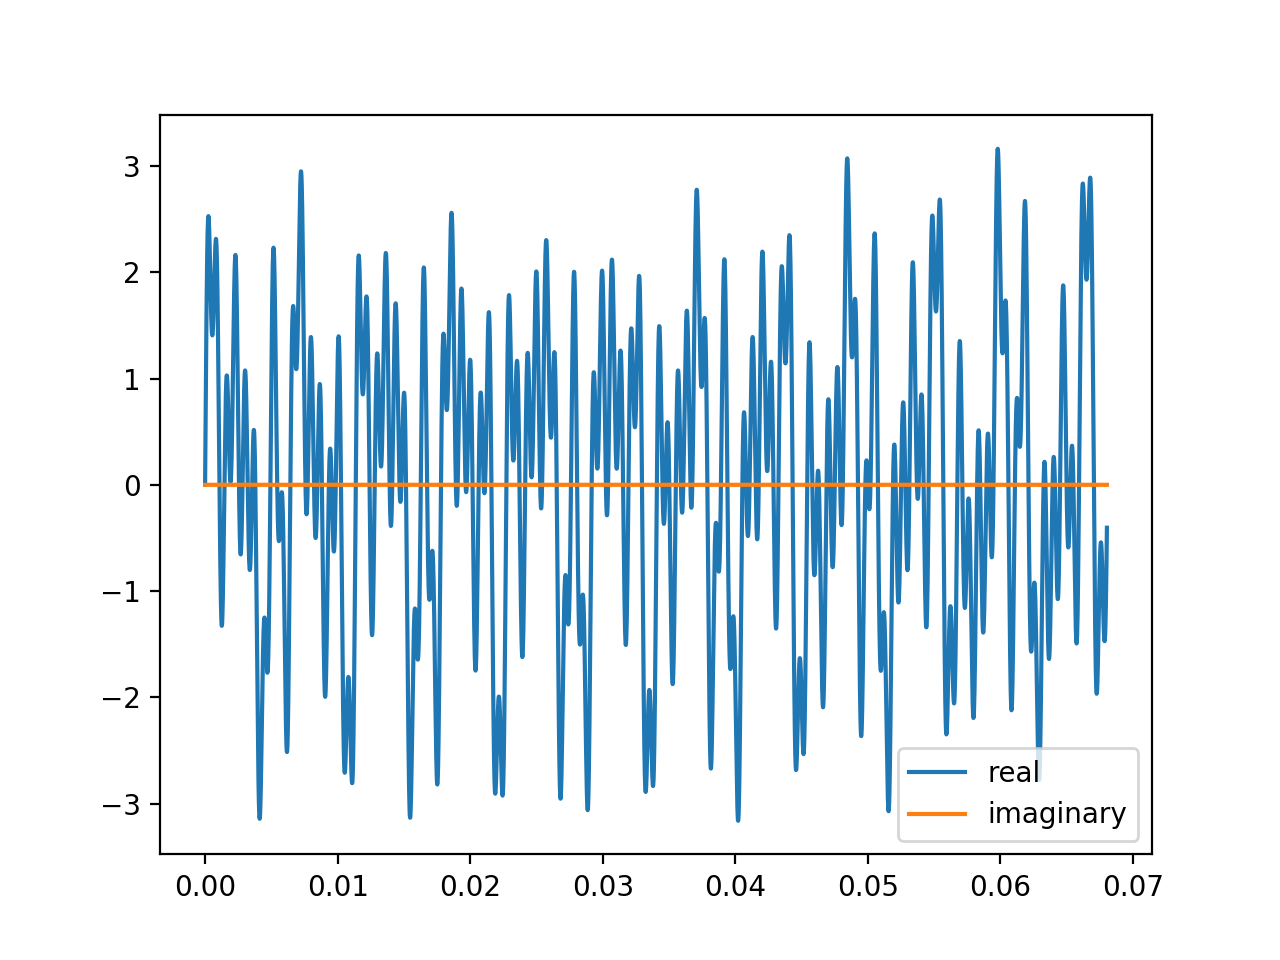

In [16]:
signal_fft = fft.fft(signal)
reconstructed_signal = fft.ifft(signal_fft)
plt.plot(time_vector, reconstructed_signal.real)
plt.plot(time_vector, reconstructed_signal.imag)
plt.legend(('real', 'imaginary'))

Plot fast fourier transform representation of a signal:

<IPython.core.display.Javascript object>


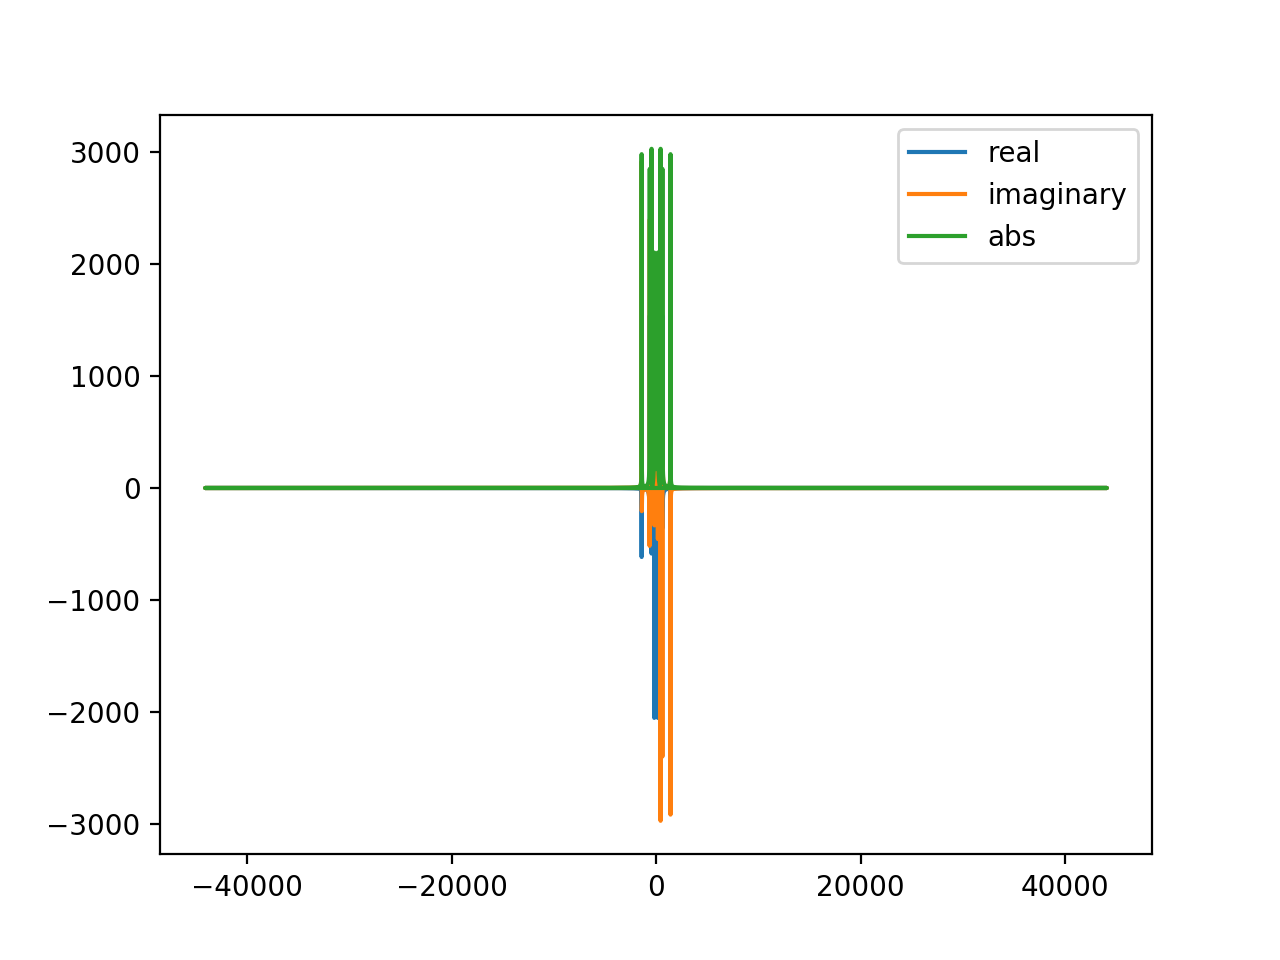

In [17]:
frequency_space = fft.fftfreq(len(signal_fft), 1 / sample_rate)
plt.plot(frequency_space, signal_fft.real)
plt.plot(frequency_space, signal_fft.imag)
plt.plot(frequency_space, np.abs(signal_fft))
plt.legend(('real', 'imaginary', 'abs'))

Reconstract signal only from major frequence components:

<IPython.core.display.Javascript object>


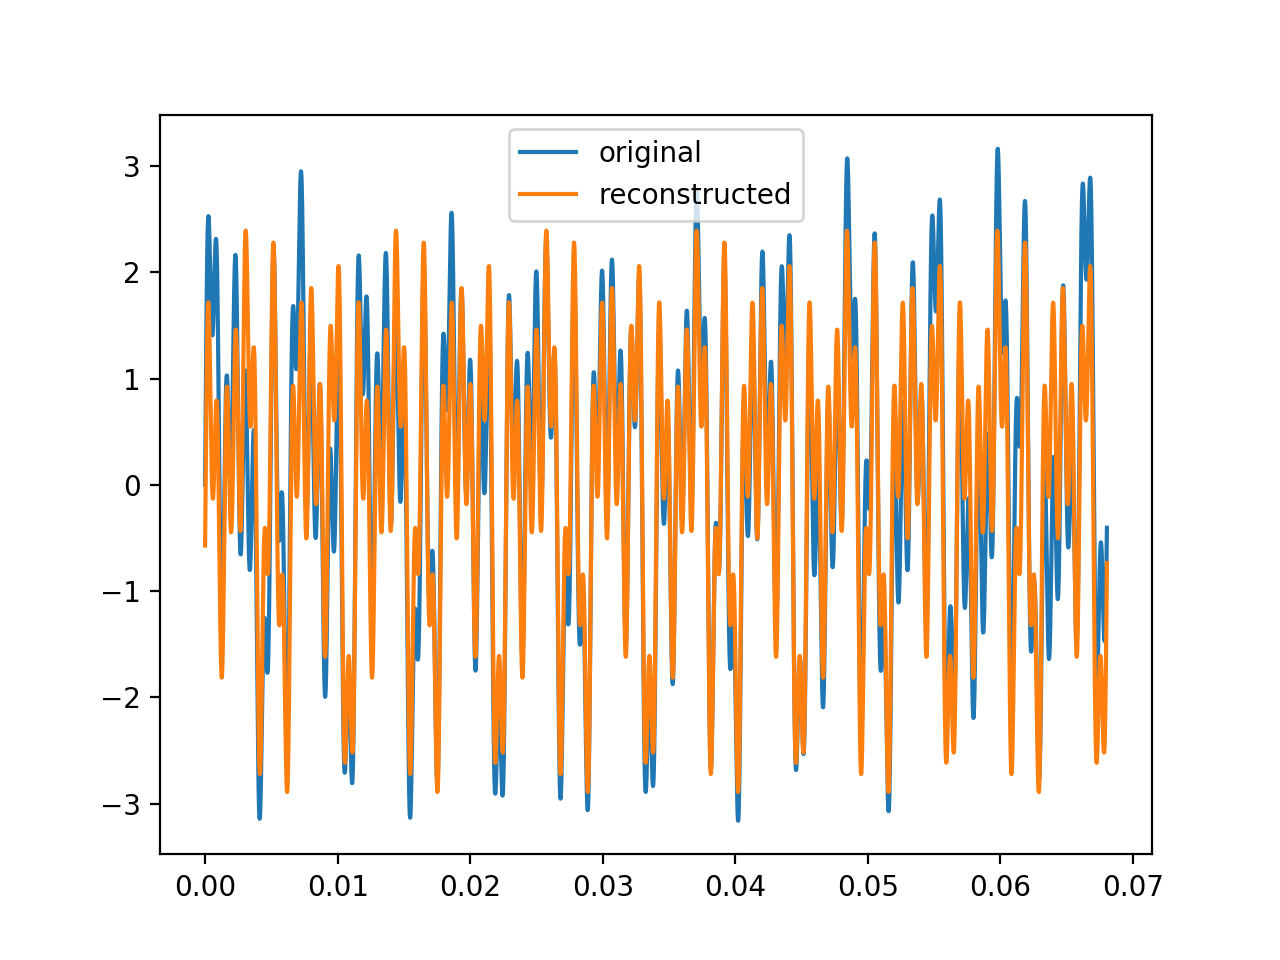

array([ -441. ,   441. ,  1411.2, -1411.2,   617.4,  -617.4,   176.4,
        -176.4])

In [18]:
simplified_fft = np.zeros(signal_fft.size, dtype=signal_fft.dtype)
top_size = signal_components * 2
top_frequences_idx = np.abs(signal_fft).argsort()[-top_size:][::-1]
for i in top_frequences_idx:
    simplified_fft[i] = signal_fft[i]

simplified_signal = fft.ifft(simplified_fft, time_vector.size)

plt.plot(time_vector, signal)
plt.plot(time_vector, simplified_signal.real)
plt.legend(('original', 'reconstructed'))

frequency_space = fft.fftfreq(len(signal_fft), 1 / sample_rate)

top_frequences = np.zeros(top_size, dtype=frequency_space.dtype)
for i in range(top_size):
    top_frequences[i] = frequency_space[top_frequences_idx[i]]
top_frequences

Play reconstructed signal:

In [20]:
simplified_signal_pg = pygame.mixer.Sound((simplified_signal.real * pg_tools.get_max_amplitude() / signal_components).astype(np.int16))
simplified_signal_pg.play(-1)
time.sleep(1)
simplified_signal_pg.stop()